In [11]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt


click_stream = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/data_refine/click_stream_final.csv')
transaction = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/data_refine/transaction_final.csv')
product = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/data_refine/product_final.csv')
customer = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/customer_add_rfm.csv')

tem = pd.merge(click_stream[['session_id', 'event_time', 'event_name']], transaction[['session_id', 'customer_id']].drop_duplicates(), on = 'session_id', how = "left")
tem2 = pd.merge(tem[tem.customer_id.notnull()], customer, on = 'customer_id', how= 'left')




In [12]:
# 시간 복잡도 개선 이전 함수
# def bounce_judge(df):
#     #측정 기간 설정
#     start_date = pd.to_datetime('2020-07-01')
#     end_date = pd.to_datetime('2022-06-30')
    
#     #측정 기간에 해당하는 월 수: 24개
#     num_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1
    
#     #이탈 판단 기준(14일 = 60 * 60 * 24 * 14 = 1209600 초)
#     criterion = 1209600

#     # 월별 컬럼 이름 생성
#     column_names = [(start_date + pd.DateOffset(months=i)).strftime('%Y-%m') for i in range(num_of_months)]

#     #데이터의 시간 데이터 타입 초기화
#     df.event_time = pd.to_datetime(df.event_time)

#     # 빈 데이터프레임 생성
#     res = pd.DataFrame(columns=column_names)

#     #customer_id를 기준으로 반복
#     for customer in df.customer_id.unique():
        
#         #베이스 딕셔너리 생성
#         tem = {month : 0 for month in sorted(column_names)}

#         #조건에 맞는 데이터로그 불러오기
#         log = df[(df.customer_id == customer) & (df.event_name == 'HOMEPAGE') & (pd.to_datetime(df.event_time.dt.date) <= end_date) & (pd.to_datetime(df.event_time.dt.date) >= start_date)].sort_values('event_time').reset_index(drop = True)

#         # 정해진 기간에 데이터가 없을 경우 log.loc[0, 'first_join_date'] 를 호출 하는 과정에서 오류 발생 함. 이를 방지하고자 데이터의 개수가 0개이면 넘어감
#         if len(log) == 0:
#             pass

#         else:    # 2020-07월 이전에 계정을 생성한 경우
#             if pd.to_datetime(log.loc[0, 'first_join_date']) < start_date:

#                 #방문 기록이 없는 달 추출하여 집합으로 저장
#                 date_set = set([date.strftime('%Y-%m') for date in log.event_time])
#                 bounce_month = set(column_names) - date_set
        
#                 #homepage 재방문 시간 계산
#                 log['diff'] = log.event_time.diff().dt.total_seconds()

#                 #첫번째 인덱스에는 start_date 부터의 시간 간격 측정
#                 log.iloc[0,4] = (pd.Timestamp(log.iloc[0,3], tz= 'UTC') - pd.Timestamp('2020-07-01 0:0:0', tz= 'UTC')).total_seconds()

#                 #bounce_month 집합에 마지막 접속일 부터 10일 지난 시점의 달 추가(합집합)
#                 bounce_month = bounce_month.union(set([date.strftime('%Y-%m') for date in log.loc[(log[log['diff'] > criterion].index - 1), 'event_time'] + timedelta(days=14)]))

#             # 2020-07월 이후에 계정을 생성한 경우
#             else:
                
#                 #start_date 이후 first_join_date 이전 월 추출(이탈 아닌것으로 확인해야하기 때문에)
#                 date_range = pd.date_range(start=start_date, end=log.first_join_date.iloc[0], freq='M')
#                 extracted_months = set(date.strftime('%Y-%m') for date in date_range)

#                 #방문 기록이 없는 달 추출하여 집합으로 저장
#                 date_set = set([date.strftime('%Y-%m') for date in log.event_time])
#                 bounce_month = set(column_names) - date_set - extracted_months
                    
#                 #homepage 재방문 시간 계산
#                 log['diff'] = log.event_time.diff().dt.total_seconds()

#                 #첫번째 인덱스에는 first_join_date 부터의 시간 간격 측정
#                 log.iloc[0,4] = (pd.Timestamp(log.iloc[0,3], tz= 'UTC') - pd.Timestamp(log.loc[0, 'first_join_date'], tz= 'UTC')).total_seconds()

#                 #bounce_month 집합에 마지막 접속일 부터 10일 지난 시점의 달 추가(합집합)
#                 bounce_month = bounce_month.union(set([date.strftime('%Y-%m') for date in log.loc[(log[log['diff'] > criterion].index - 1), 'event_time'] + timedelta(days=14)]))

#         #이탈(1) 입력
#         for month in bounce_month:
#             tem[month] = 1
    
#         #customer_id 와 key에 대해 이탈여부 매칭하는 데이터프레임 만들기
#         for key in tem:
#             res.loc[customer, key] = int(tem[key])
    
#     return res

# homepage 페이지 방문 기준 이탈

## 이탈 함수

In [13]:
#함수 사용에 필요한 특성
#click_stream
#   event_name: 'HOMEPAGE' 인 이벤트만 조회하기 때문에
#   event_time: 재방문에 걸린 시간 조회하기 위해
#   session_id: transaction 테이블과 병합하여 customer_id를 얻기 위해
#transaction
#   session_id: click_stream 테이블과 병합하여 customer_id를 얻기 위해
#   customer_id: customer 테이블과 병합하여 first_join_date 를 얻기 위해
#customer
#   customer_id: click_stream 테이블과 병합하여 first_join_date 를 얻기 위해
#   first_join_date: 가입 시기를 알기 위해



def bounce_judge(df, days_cri = 10):
    # 측정 기간 설정
    start_date = pd.to_datetime('2020-08-01')
    end_date = pd.to_datetime('2022-07-31')
    
    # 측정 기간에 해당하는 월 수: 24개
    num_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1
    
    # 이탈 판단 기준(days_cir = 기준이 되는 일)
    criterion = 60 * 60 * 24 * days_cri

    # 월별 이름 생성
    column_names = [(start_date + pd.DateOffset(months=i)).strftime('%Y-%m') for i in range(num_of_months)]

    # 데이터의 시간 데이터 타입 초기화
    df.event_time = pd.to_datetime(df.event_time)

    # 빈 딕셔너리 생성
    res = {}

    # customer_id를 기준으로 그룹화
    grouped = df[(df.event_name == 'HOMEPAGE') & (pd.to_datetime(df.event_time.dt.date) <= end_date) & (pd.to_datetime(df.event_time.dt.date) >= start_date)].groupby('customer_id')

    #grouped 에 포함되지 않는 데이터 처리
    excluded_ids_set = set(df[~df.customer_id.isin(grouped.groups.keys())]['customer_id']) #grouped 에 포함되지 않는 customer_id 집합
    first_join_dates = df[df.customer_id.isin(excluded_ids_set)].groupby('customer_id').first_join_date.first() #위 집합에 포함된 customer_id의 first_join_dates
    
    
    # excluded_ids를 순회하면서 이탈 여부 결정
    for customer in excluded_ids_set:
        f_j = pd.to_datetime(first_join_dates[customer])
        
        #start_date 이전에 가입했지만 2020/07~2022/06 기간동안 접속 안한 경우 이탈(1)
        if f_j < start_date:
            res[customer] = [1] * num_of_months

        #start_date 이후에 가입하여 2020/07~2022/06 기간동안 데이터가 없는 경우 이탈X(0)            
        elif f_j > end_date:
            res[customer] = [0] * num_of_months


    
    # 각 그룹 별로 작업 수행
    for customer, log in grouped:
        tem = {month: 0 for month in sorted(column_names)}
            
        # 방문 기록이 없는 달 추출하여 집합으로 저장
        date_set = set([date.strftime('%Y-%m') for date in log.event_time])
        bounce_month = set(column_names) - date_set

        # homepage 재방문 시간 계산
        log['diff'] = log.event_time.diff().dt.total_seconds()
        log.reset_index(drop = True, inplace = True)

            
        first_index = log.index[0]
        log_index = log[log['diff'] > criterion].index
            
        # .diff() 함수 적용시 첫 행에 나오는 nan 값에 대한 처리
        # fisrt_join date < start_date 일 경우 start_date ~ 첫번째 homepage event 발생 시점까지의 시간을 첫 행에 입력
        if pd.to_datetime(log.loc[first_index, 'first_join_date']) < start_date:
            log.at[first_index, 'diff'] = (log.at[first_index, 'event_time'] - pd.Timestamp('2020-08-01 0:0:0', tz='UTC')).total_seconds()

            #위에서 계산한 값이 criterion 값보다 클 경우 아래 로직에서 (0 - 1)이 계산 되어 음수 인덱스로 인한 에러 발생 / 첫 행에 대해서는 기준 보다 클 때 첫번째 event_time 의 연/월에 이탈(1) 처리
            if log.at[first_index, 'diff'] > criterion:
                bounce_month.add(log.at[first_index, 'event_time'].strftime('%Y-%m'))
                log_index = log[log['diff'] > criterion].index.drop(0) #아래 로직에서 오류 발생하지 않게 0번 인덱스 드랍(위에서 해당 행에 대해 이탈 여부를 처리함)

        # fisrt_join date >= start_date 일 경우 start_date ~ fisrt_join_date 시점까지의 연/월에 대해 이탈X(0) 처리 / first_join_date ~ 첫번째 homepage event 발생 시점까지의 시간을 첫 행에 입력
        else:
            date_range = pd.date_range(start=start_date, end=log.first_join_date.iloc[0], freq='M')
            extracted_months = set(date.strftime('%Y-%m') for date in date_range)
            log.at[first_index, 'diff'] = (log.at[first_index, 'event_time'] - pd.Timestamp(log.at[first_index, 'first_join_date'], tz='UTC')).total_seconds()
            bounce_month -= extracted_months
        
        # bounce_month 집합에 마지막 접속일 부터 10일 지난 시점의 달 추가(합집합)
        bounce_month = bounce_month.union(set([date.strftime('%Y-%m') for date in log.loc[(log_index - 1), 'event_time'] + timedelta(days= days_cri)]))

        # 이탈(1) 입력
        for month in bounce_month:
            tem[month] = 1

        # customer_id와 key에 대해 이탈 여부 매칭하는 딕셔너리 만들기
        res[customer] = [int(tem[key]) for key in sorted(tem.keys())]

    # 딕셔너리를 데이터프레임으로 변환
    res_df = pd.DataFrame.from_dict(res, orient='index', columns=column_names)
    
    return res_df


## 함수 적용

### 누적

In [14]:
x_tick = ['2020/08', '2020/09', '2020/10', '2020/11', '2020/12',
'2021/01', '2021/02', '2021/03', '2021/04', '2021/05', '2021/06', '2021/07', '2021/08', '2021/09', '2021/10', '2021/11', '2021/12',
'2022/01', '2022/02', '2022/03', '2022/04', '2022/05', '2022/06', '2022/07']

In [15]:
#월간 신규 가입 고객 수 계산
def monthly_join_user(df):
    list = []
    for i in range(1,13):
        list.append(len(df[df.first_join_date.dt.month == i]))
        year = df.first_join_date.dt.year.unique()[0]
    return [list, year]

#월간 신규 가입 고객 수 그래프 
def plot_monthly_graph(df):
    plt.figure(figsize=(10, 6))
    plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], df[0])
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xlabel('Month')
    plt.ylabel('User')
    plt.title(f'{df[1]} MONTHLY JOIN USER')
    return plt.show

In [16]:
#연도별 신규 가입 고객 수 계산

customer.first_join_date = pd.to_datetime(customer.first_join_date)

join_2016 = customer[customer.first_join_date.dt.year == 2016]
join_2017 = customer[customer.first_join_date.dt.year == 2017]
join_2018 = customer[customer.first_join_date.dt.year == 2018]
join_2019 = customer[customer.first_join_date.dt.year == 2019]
join_2020 = customer[customer.first_join_date.dt.year == 2020]
join_2021 = customer[customer.first_join_date.dt.year == 2021]
join_2022 = customer[customer.first_join_date.dt.year == 2022]

join_count = pd.DataFrame([len(join_2016), len(join_2017), len(join_2018), len(join_2019), len(join_2020), len(join_2021), len(join_2022)])

In [17]:
# 전체 기간 누적 고객 수 구하기
#concat 하기 위해 데이터 프레임으로 변경
monthly_2016 = pd.DataFrame(monthly_join_user(join_2016)[0])
monthly_2017 = pd.DataFrame(monthly_join_user(join_2017)[0])
monthly_2018 = pd.DataFrame(monthly_join_user(join_2018)[0])
monthly_2019 = pd.DataFrame(monthly_join_user(join_2019)[0])
monthly_2020 = pd.DataFrame(monthly_join_user(join_2020)[0])
monthly_2021 = pd.DataFrame(monthly_join_user(join_2021)[0])
monthly_2022 = pd.DataFrame(monthly_join_user(join_2022)[0])

#전체 기간 concat
monthly_total = pd.concat([monthly_2016, monthly_2017, monthly_2018, monthly_2019, monthly_2020, monthly_2021, monthly_2022]).reset_index(drop = True)

#전체 기간 누적 데이터 생성
monthly_total['Cumulative People'] = monthly_total[0].cumsum()


### 10일 기준

In [18]:
# bounce_10 = bounce_judge(tem2, 10)

In [19]:
# import matplotlib.pyplot as plt

# b_10 = bounce_10.sum(axis = 0)

# bounce_rate_10 = []
# for i in range(len(b_10)):
#     bounce_rate_10.append(b_10.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_10)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

### 11일 기준

In [20]:
# bounce_11 = bounce_judge(tem2, 11)

In [21]:
# import matplotlib.pyplot as plt

# b_11 = bounce_11.sum(axis = 0)

# bounce_rate_11 = []
# for i in range(len(b_11)):
#     bounce_rate_11.append(b_11.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_11)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

### 14일 기준

In [22]:
# bounce_14 = bounce_judge(tem2, 14)

In [23]:
# import matplotlib.pyplot as plt

# b_14 = bounce_14.sum(axis = 0)

# bounce_rate_14 = []
# for i in range(len(b_14)):
#     bounce_rate_14.append(b_14.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_14)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

### 1.5일 기준

In [24]:
# bounce_1_5 = bounce_judge(tem2, 1.5)

In [25]:
# import matplotlib.pyplot as plt

# b_1_5 = bounce_1_5.sum(axis = 0)

# bounce_rate_1_5 = []
# for i in range(len(b_1_5)):
#     bounce_rate_1_5.append(b_1_5.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_1_5)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

# booking 페이지 방문 기준 이탈

In [26]:
#함수 사용에 필요한 특성
#click_stream
#   event_name: 'HOMEPAGE' 인 이벤트만 조회하기 때문에
#   event_time: 재방문에 걸린 시간 조회하기 위해
#   session_id: transaction 테이블과 병합하여 customer_id를 얻기 위해
#transaction
#   session_id: click_stream 테이블과 병합하여 customer_id를 얻기 위해
#   customer_id: customer 테이블과 병합하여 first_join_date 를 얻기 위해
#customer
#   customer_id: click_stream 테이블과 병합하여 first_join_date 를 얻기 위해
#   first_join_date: 가입 시기를 알기 위해



def bounce_judge_book(df, days_cri = 25):
    # 측정 기간 설정
    start_date = pd.to_datetime('2020-08-01')
    end_date = pd.to_datetime('2022-07-31')
    
    # 측정 기간에 해당하는 월 수: 24개
    num_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1
    
    # 이탈 판단 기준(days_cir = 기준이 되는 일)
    criterion = 60 * 60 * 24 * days_cri

    # 월별 이름 생성
    column_names = [(start_date + pd.DateOffset(months=i)).strftime('%Y-%m') for i in range(num_of_months)]

    # 데이터의 시간 데이터 타입 초기화
    df.event_time = pd.to_datetime(df.event_time)

    # 빈 딕셔너리 생성
    res = {}

    # customer_id를 기준으로 그룹화
    grouped = df[(df.event_name == 'BOOKING') & (pd.to_datetime(df.event_time.dt.date) <= end_date) & (pd.to_datetime(df.event_time.dt.date) >= start_date)].groupby('customer_id')

    #grouped 에 포함되지 않는 데이터 처리
    excluded_ids_set = set(df[~df.customer_id.isin(grouped.groups.keys())]['customer_id']) #grouped 에 포함되지 않는 customer_id 집합
    first_join_dates = df[df.customer_id.isin(excluded_ids_set)].groupby('customer_id').first_join_date.first() #위 집합에 포함된 customer_id의 first_join_dates
    
    
    # excluded_ids를 순회하면서 이탈 여부 결정
    for customer in excluded_ids_set:
        f_j = pd.to_datetime(first_join_dates[customer])
        
        #start_date 이전에 가입했지만 2020/07~2022/06 기간동안 접속 안한 경우 이탈(1)
        if f_j < start_date:
            res[customer] = [1] * num_of_months

        #start_date 이후에 가입하여 2020/07~2022/06 기간동안 데이터가 없는 경우 이탈X(0)            
        elif f_j > end_date:
            res[customer] = [0] * num_of_months


    
    # 각 그룹 별로 작업 수행
    for customer, log in grouped:
        tem = {month: 0 for month in sorted(column_names)}
            
        # 방문 기록이 없는 달 추출하여 집합으로 저장
        date_set = set([date.strftime('%Y-%m') for date in log.event_time])
        bounce_month = set(column_names) - date_set

        # homepage 재방문 시간 계산
        log['diff'] = log.event_time.diff().dt.total_seconds()
        log.reset_index(drop = True, inplace = True)

            
        first_index = log.index[0]
        log_index = log[log['diff'] > criterion].index
            
        # .diff() 함수 적용시 첫 행에 나오는 nan 값에 대한 처리
        # fisrt_join date < start_date 일 경우 start_date ~ 첫번째 homepage event 발생 시점까지의 시간을 첫 행에 입력
        if pd.to_datetime(log.loc[first_index, 'first_join_date']) < start_date:
            log.at[first_index, 'diff'] = (log.at[first_index, 'event_time'] - pd.Timestamp('2020-08-01 0:0:0', tz='UTC')).total_seconds()

            #위에서 계산한 값이 criterion 값보다 클 경우 아래 로직에서 (0 - 1)이 계산 되어 음수 인덱스로 인한 에러 발생 / 첫 행에 대해서는 기준 보다 클 때 첫번째 event_time 의 연/월에 이탈(1) 처리
            if log.at[first_index, 'diff'] > criterion:
                bounce_month.add(log.at[first_index, 'event_time'].strftime('%Y-%m'))
                log_index = log[log['diff'] > criterion].index.drop(0) #아래 로직에서 오류 발생하지 않게 0번 인덱스 드랍(위에서 해당 행에 대해 이탈 여부를 처리함)

        # fisrt_join date >= start_date 일 경우 start_date ~ fisrt_join_date 시점까지의 연/월에 대해 이탈X(0) 처리 / first_join_date ~ 첫번째 homepage event 발생 시점까지의 시간을 첫 행에 입력
        else:
            date_range = pd.date_range(start=start_date, end=log.first_join_date.iloc[0], freq='M')
            extracted_months = set(date.strftime('%Y-%m') for date in date_range)
            log.at[first_index, 'diff'] = (log.at[first_index, 'event_time'] - pd.Timestamp(log.at[first_index, 'first_join_date'], tz='UTC')).total_seconds()
            bounce_month -= extracted_months
        
        # bounce_month 집합에 마지막 접속일 부터 10일 지난 시점의 달 추가(합집합)
        bounce_month = bounce_month.union(set([date.strftime('%Y-%m') for date in log.loc[(log_index - 1), 'event_time'] + timedelta(days= days_cri)]))

        # 이탈(1) 입력
        for month in bounce_month:
            tem[month] = 1

        # customer_id와 key에 대해 이탈 여부 매칭하는 딕셔너리 만들기
        res[customer] = [int(tem[key]) for key in sorted(tem.keys())]

    # 딕셔너리를 데이터프레임으로 변환
    res_df = pd.DataFrame.from_dict(res, orient='index', columns=column_names)
    
    return res_df


In [27]:
# bounce_21_book = bounce_judge_book(tem2, 21)
# bounce_43_book = bounce_judge_book(tem2, 43)
# bounce_44_book = bounce_judge_book(tem2, 44)


### MEAN 기준

In [28]:
# import matplotlib.pyplot as plt

# b_43_book = bounce_43_book.sum(axis = 0)

# bounce_rate_43_book = []
# for i in range(len(b_43_book)):
#     bounce_rate_43_book.append(b_43_book.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_43_book)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

### 75% 기준

In [29]:
# import matplotlib.pyplot as plt

# b_44_book = bounce_44_book.sum(axis = 0)

# bounce_rate_44_book = []
# for i in range(len(b_44_book)):
#     bounce_rate_44_book.append(b_44_book.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_44_book)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

### MEDIAN 기준

In [30]:
# import matplotlib.pyplot as plt

# b_21_book = bounce_21_book.sum(axis = 0)

# bounce_rate_21_book = []
# for i in range(len(b_21_book)):
#     bounce_rate_21_book.append(b_21_book.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

# plt.figure(figsize=(10, 6))
# plt.plot(bounce_rate_21_book)
# plt.xticks(range(0, 24), x_tick, rotation= 45)
# plt.show;

In [31]:
# tem2[tem2.event_name == 'BOOKING']

In [32]:
tem2.session_id.nunique()

852582

In [33]:
df_buy_split_book = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/df_buy_split_book.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/df_buy_split_book.csv'

In [ ]:
df_buy_split_book.session_id.nunique()

# 최종 함수 (booking 기준 25일 구매)


In [34]:
bounce_25_book = bounce_judge_book(tem2, 25)


In [35]:
bounce_25_book

,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,...,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07
65539.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
98311.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
98312.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
98323.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
32789.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99989.0,0,0,0,0,0,0,0,0,1,1,...,1,1,1,1,1,1,0,1,1,1
99991.0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,0,1,1,1,1,1
99992.0,1,1,1,1,1,1,1,0,1,0,...,1,0,1,0,1,0,1,0,1,1
99995.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 전체 이탈율 추이

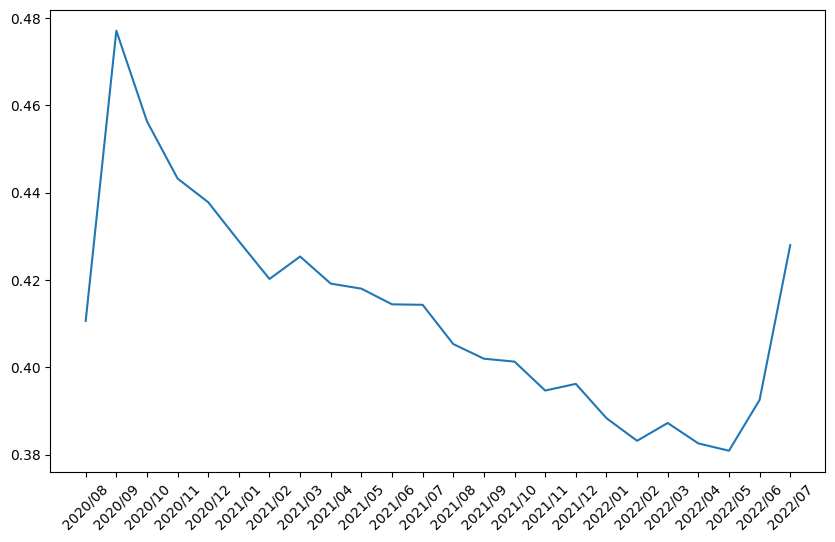

In [67]:
b_25 = bounce_25_book.sum(axis = 0)

bounce_rate_25 = []
for i in range(len(b_25)):
    bounce_rate_25.append(b_25.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

plt.figure(figsize=(10, 6))
plt.plot(bounce_rate_25)
plt.xticks(range(0, 24), x_tick, rotation= 45)
plt.show;

## 세그먼트 별 이탈율 추이

In [40]:
cus_322 = customer[customer['RFM_Segment_y'] == 322].customer_id
cus_222 = customer[customer['RFM_Segment_y'] == 222].customer_id
cus_122 = customer[customer['RFM_Segment_y'] == 122].customer_id

In [50]:
bounce_25_book_322 = bounce_25_book[bounce_25_book.index.isin(cus_322)]
bounce_25_book_222 = bounce_25_book[bounce_25_book.index.isin(cus_222)]
bounce_25_book_122 = bounce_25_book[bounce_25_book.index.isin(cus_122)]

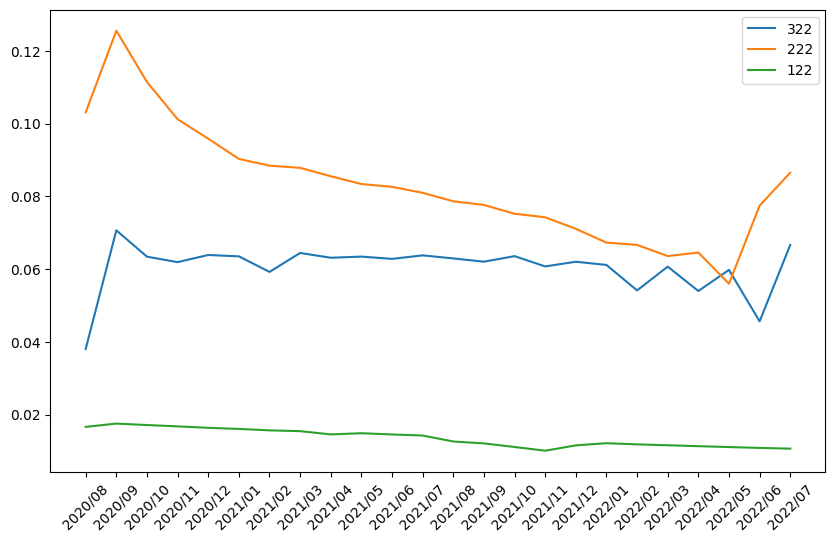

In [61]:
b_25_322 = bounce_25_book_322.sum(axis = 0)
b_25_222 = bounce_25_book_222.sum(axis = 0)
b_25_122 = bounce_25_book_122.sum(axis = 0)

bounce_rate_25_322 = []
for i in range(len(b_25_322)):
    bounce_rate_25_322.append(b_25_322.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

bounce_rate_25_222 = []
for i in range(len(b_25_222)):
    bounce_rate_25_222.append(b_25_222.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

bounce_rate_25_122 = []
for i in range(len(b_25_122)):
    bounce_rate_25_122.append(b_25_122.iloc[i] / monthly_total[54:78]['Cumulative People'].iloc[i])

plt.figure(figsize=(10, 6))
plt.plot(bounce_rate_25_322, label = '322')
plt.plot(bounce_rate_25_222, label = '222')
plt.plot(bounce_rate_25_122, label = '122')
plt.legend()
plt.xticks(range(0, 24), x_tick, rotation= 45)
plt.show;


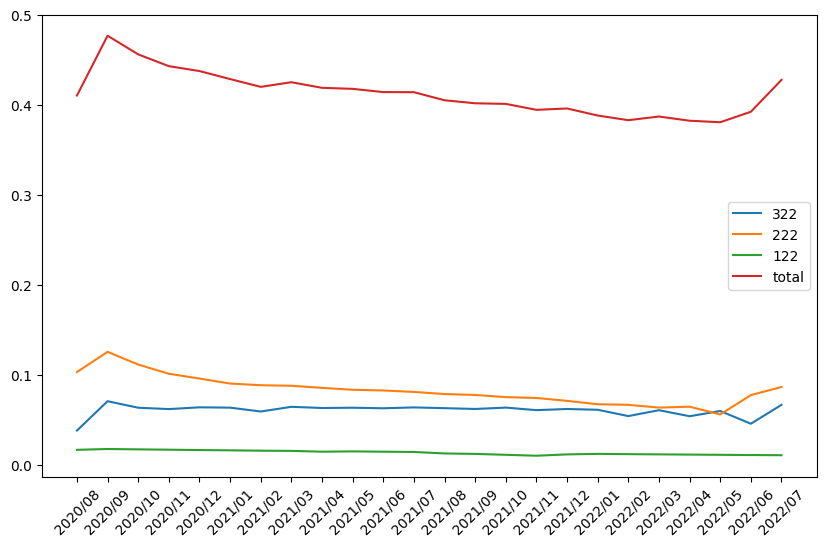

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(bounce_rate_25_322, label = '322')
plt.plot(bounce_rate_25_222, label = '222')
plt.plot(bounce_rate_25_122, label = '122')
plt.plot(bounce_rate_25[-24:], label = 'total')
plt.legend()
plt.xticks(range(0, 24), x_tick, rotation= 45)
plt.show;